In [2]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_data(folder='results'):
    data = {}
    test_types = os.listdir(folder)
    for test_type in test_types:
        path = f'{folder}/{test_type}/deals_history.pkl'
        with open(path, 'rb') as f:
            result = processing_data(pickle.load(f))
            data[test_type] = result
    return data


def processing_data(data):
    data = (pd.DataFrame(data)
        .dropna()
        .assign(balance_profit = lambda _df: 100 * (_df.close_balance-_df.entry_balance) / _df.close_balance)
        .assign(profit = lambda _df: 100 * (_df.close_price-_df.entry_price) / _df.close_price)
    )
    return data

In [4]:
data = load_data()
test_types = list(data)
test_types.sort()

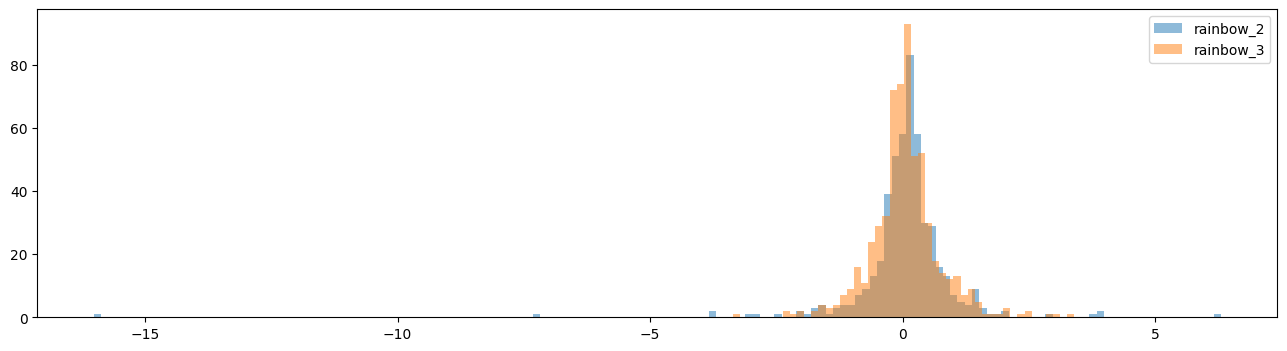

In [5]:
using_results = ['rainbow_2', 'rainbow_3']
plt.figure(figsize=(16,4))
for test_type in test_types:
    if test_type not in using_results:
        continue
    plt.hist(data[test_type].profit, bins='auto', label=test_type, alpha=0.5)
plt.legend()

In [6]:
for test_type in test_types:
    print(f'{test_type} avg profit: {data[test_type].profit.mean():.3f}')

base_dqn avg profit: 0.115
double_dqn avg profit: 0.063
dueling_dqn avg profit: 0.084
rainbow_2 avg profit: 0.056
rainbow_3 avg profit: 0.049


In [7]:
for test_type in test_types:
    print(f'{test_type} median profit: {data[test_type].profit.median():.3f}')

base_dqn median profit: 0.084
double_dqn median profit: 0.041
dueling_dqn median profit: 0.120
rainbow_2 median profit: 0.115
rainbow_3 median profit: 0.039


In [8]:
for test_type in test_types:
    print(f'{test_type} median profit: {data[test_type].balance_profit.mean():.3f}')

base_dqn median profit: 0.015
double_dqn median profit: -0.037
dueling_dqn median profit: -0.016
rainbow_2 median profit: -0.043
rainbow_3 median profit: -0.050


In [9]:
clip_value = 0.5
for test_type in test_types:
    print(f'Clip [-{clip_value}, {clip_value}] {test_type} avg profit: {data[test_type].profit.mean():.3f}')

# print(f'Clip [-{clip_value}, {clip_value}] Base avg profit: {base_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Double avg profit: {double_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Dueling avg profit: {dueling_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Rainbow2 avg profit: {rainbow2_results.profit.clip(-clip_value,clip_value).mean():.3f}')

Clip [-0.5, 0.5] base_dqn avg profit: 0.115
Clip [-0.5, 0.5] double_dqn avg profit: 0.063
Clip [-0.5, 0.5] dueling_dqn avg profit: 0.084
Clip [-0.5, 0.5] rainbow_2 avg profit: 0.056
Clip [-0.5, 0.5] rainbow_3 avg profit: 0.049


In [10]:
for test_type in test_types:
    print(f'{test_type} std profit: {data[test_type].profit.std():.3f}')

base_dqn std profit: 0.812
double_dqn std profit: 0.775
dueling_dqn std profit: 0.750
rainbow_2 std profit: 1.127
rainbow_3 std profit: 0.690


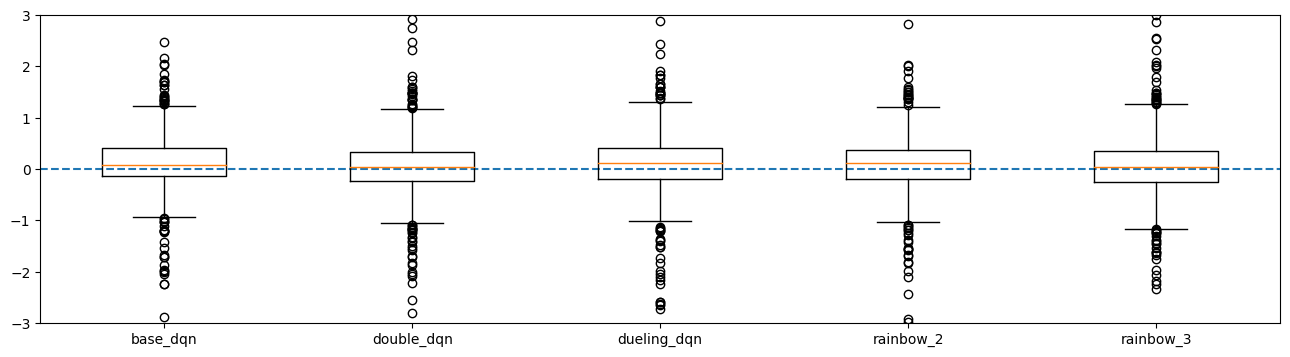

In [11]:
plt.figure(figsize=(16,4))
plt.axhline(0, linestyle='--')
plt.boxplot([data[test_type].profit.values for test_type in test_types], labels=test_types)
plt.ylim(-3,3)
# plt.legend()
print()

In [12]:
import numpy as np

In [13]:
for test_type in test_types:
    coef = np.corrcoef(data[test_type].profit, data[test_type].predict_q)
    print(f'{test_type} corr coef with profit and Q value: {coef[0, 1]:.3f}')

base_dqn corr coef with profit and Q value: -0.004
double_dqn corr coef with profit and Q value: 0.023
dueling_dqn corr coef with profit and Q value: 0.042
rainbow_2 corr coef with profit and Q value: 0.092
rainbow_3 corr coef with profit and Q value: 0.040


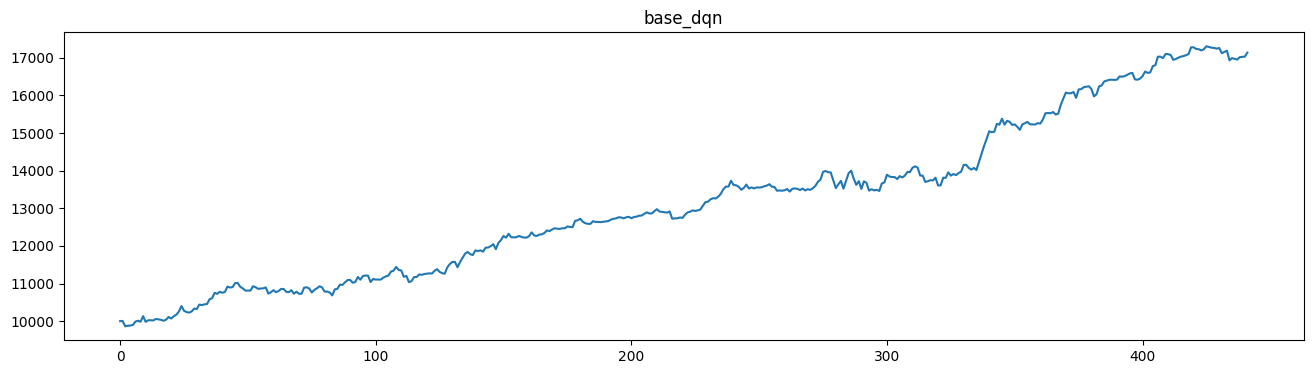

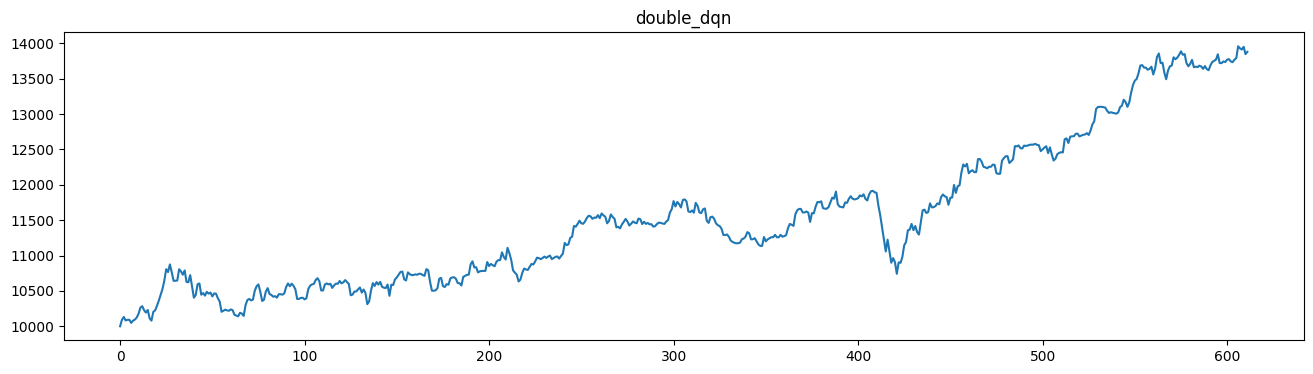

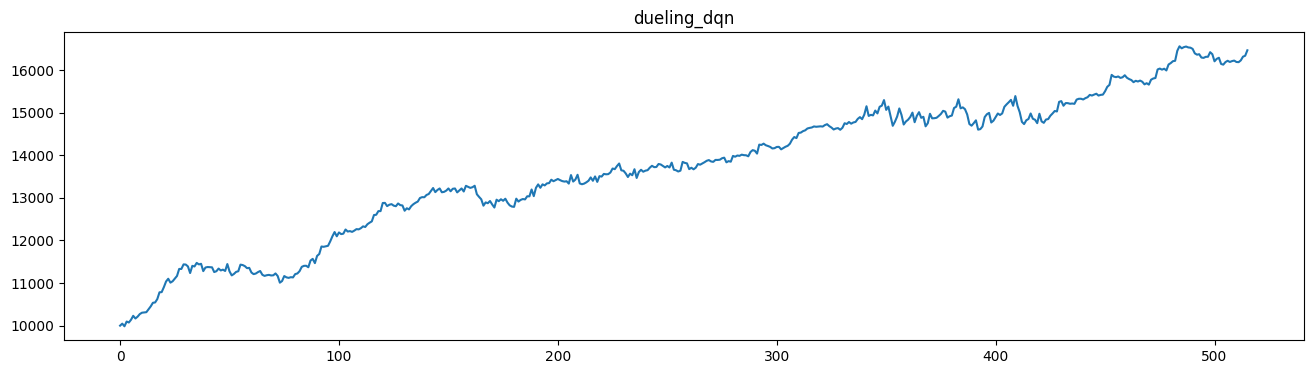

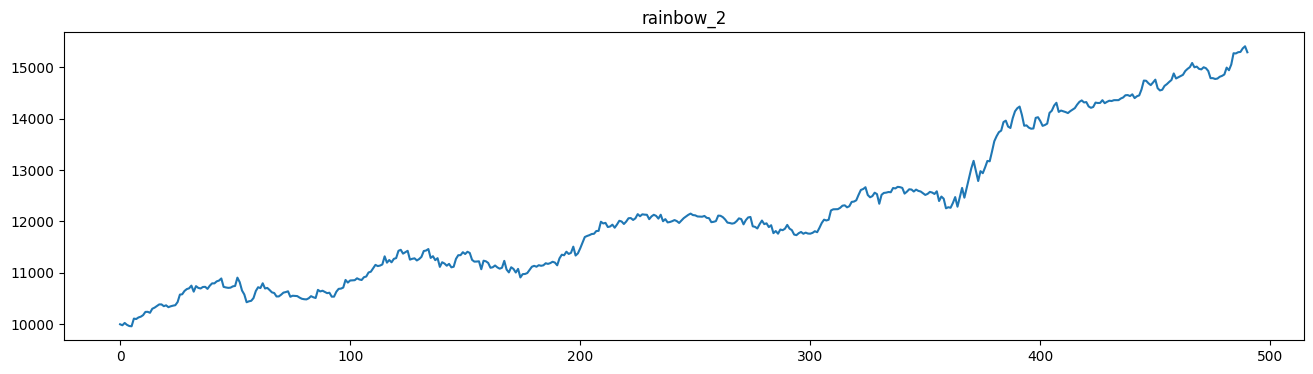

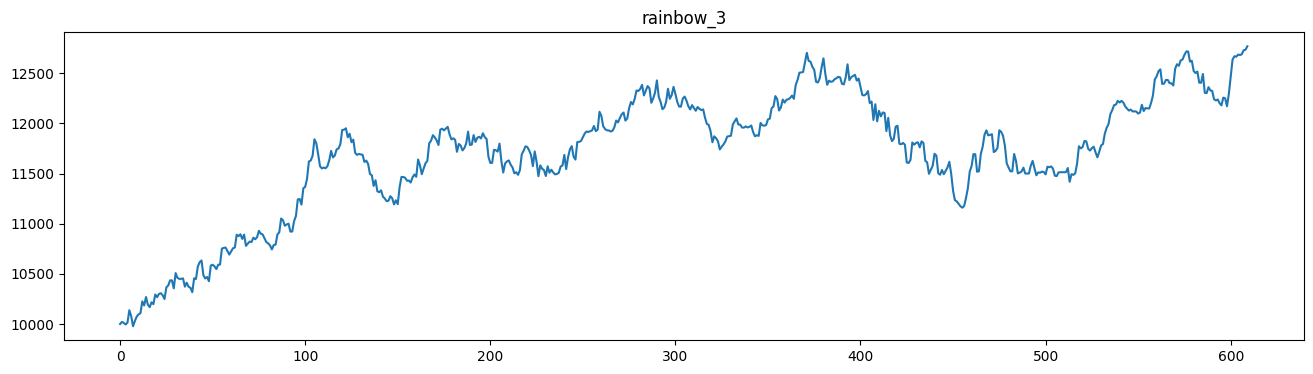

In [15]:
for test_type in test_types:
    profit = 1 + data[test_type].profit.clip(-1.5, 1.5)/100 
    balance = [10_000]
    for it in profit:
        balance.append(balance[-1]*it)
    
    plt.figure(figsize=(16,4))
    plt.title(test_type)
    plt.plot(balance)